In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!{"ros2 run local_planning_performance_modelling compute_metrics -s"}

finished computing metrics 
finished writing results 


In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter2': 'cyan', 'turtlebot3_waffle_performance_modelling': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.marker'] = 'o'

In [4]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]
navigation_metrics = [c for c in metrics if c in ['trajectory_length', 'execution_time', 'success_rate']]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

## Number of Runs

    1152

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['hunter2', 'turtlebot3_waffle_performance_modelling']

    run_index                                                              [0]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    controller_cpu_time                                                    min:       0.82             avg:      111.8             max:       1031]

    planner_cpu_time                                                       min:       0.32             avg:      31.38             max:      317.3]

    system_cpu_time                                                        min:       3.27             avg:      156.1             max:       1303]

    controller_max_memory                                                  min:      22.73             avg:      61.74             max:      78.79]

    planner_max_memory                                                     min:      25.05             avg:       1096             max:  3.109e+04]

    system_max_memory                                                      min:      137.6             avg:       1282             max:  3.126e+04]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length                                                      min:          0             avg:      18.98             max:      133.9]

    trajectory_length_version                                              [1]

    execution_time                                                         min:      0.294             avg:      85.78             max:      648.1]

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.6389             max:          1]

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   1.43e-17             avg:    0.06515             max:      4.194]

    odometry_error_alpha_1_std                                             min:          0             avg:      0.102             max:       13.9]

    odometry_error_alpha_2_mean                                            min:  4.546e-18             avg:    0.08696             max:      9.154]

    odometry_error_alpha_2_std                                             min:          0             avg:      0.156             max:      18.24]

    odometry_error_alpha_3_mean                                            min:  2.061e-17             avg:    0.06036             max:     0.8207]

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01663             max:      1.417]

    odometry_error_alpha_4_mean                                            min:  1.629e-17             avg:     0.2283             max:      1.091]

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2271             max:      1.326]

    odometry_error_version                                                 [1]

    localization_update_absolute_translation_error_mean                    min:   0.001657             avg:     0.1026             max:      1.698]

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.05115             max:      1.557]

    localization_update_absolute_rotation_error_mean                       min:  0.0003956             avg:    0.02673             max:      1.145]

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.03501             max:      1.299]

    localization_update_relative_translation_error_mean                    min:   0.001501             avg:    0.01118             max:    0.04416]

    localization_update_relative_translation_error_std                     min:          0             avg:   0.009161             max:     0.1176]

    localization_update_relative_rotation_error_mean                       min:  0.0002547             avg:   0.009268             max:     0.3784]

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.02685             max:     0.6435]

    localization_update_normalized_relative_translation_error_mean         min:    0.00547             avg:    0.06239             max:       1.29]

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.06639             max:      3.343]

    localization_update_normalized_relative_rotation_error_mean            min:   0.005765             avg:     0.1102             max:      4.205]

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.4718             max:      17.02]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:     0.3642             avg:      1.128             max:         11]

    localization_update_rate_std                                           min:          0             avg:     0.6583             max:      14.34]

    localization_update_rate_version                                       [1]

In [5]:
print(len(df.run_id.unique()))

1152


In [6]:
print('\n'.join(sorted(df.session_id.unique())))

2021-11-02_10-33-14_965419
2021-11-02_13-54-20_413082
2021-11-02_16-20-43_405511
2021-11-02_16-44-01_042364
2021-11-03_03-23-26_500136
2021-11-03_22-12-57_836780
2021-11-04_08-00-57_167708


In [7]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg'])[navigation_metrics].agg(['mean', 'count'])

trajectory_length       execution_time       success_rate      
                                                                                               mean count           mean count         mean count
robot_model                             local_planner_node max_steering_angle_deg                                                                
hunter2                                 teb                20.000                            16.777   191         90.143   191        0.411   192
                                                           40.000                            13.530   191         73.050   191        0.406   192
turtlebot3_waffle_performance_modelling dwb                90.000                            23.430    96         96.474    96        1.000    96
                                        rpp                90.000                            28.603    96         83.690    96        0.594    96
                                        teb                20.000                            23.548   192        112.592   192        0.729   192
                                                           40.000                            21.764   191         96.641   191        0.880   192
                                                           90.000                            12.105   188         51.481   188        0.609   192

In [8]:
df.groupby(['robot_model', 'alpha_1'])[odometry_mean_metrics].mean()

odometry_error_alpha_1_mean  odometry_error_alpha_2_mean  odometry_error_alpha_3_mean  odometry_error_alpha_4_mean
robot_model                             alpha_1                                                                                                                    
hunter2                                 0.000                          0.000                        0.000                        0.000                        0.000
                                        0.020                          0.017                        0.008                        0.020                        0.087
                                        0.050                          0.042                        0.022                        0.050                        0.222
                                        0.100                          0.086                        0.047                        0.099                        0.384
turtlebot3_waffle_performance_modelling 0.000                          0.000                        0.000                        0.000                        0.000
                                        0.020                          0.032                        0.052                        0.025                        0.094
                                        0.050                          0.056                        0.076                        0.057                        0.235
                                        0.100                          0.150                        0.241                        0.123                        0.421

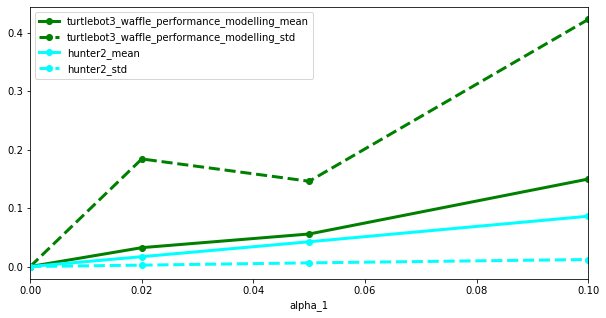

In [9]:
for robot_model in df.robot_model.unique():
    df[df.robot_model == robot_model].groupby('alpha_1').odometry_error_alpha_1_mean.mean().plot(x='alpha_1', figsize=[10, 5], label=robot_model+'_mean', color=robot_model_color[robot_model])
    df[df.robot_model == robot_model].groupby('alpha_1').odometry_error_alpha_1_mean.std().plot(x='alpha_1', figsize=[10, 5], label=robot_model+'_std', color=robot_model_color[robot_model], linestyle='dashed')
plt.legend()
plt.show()

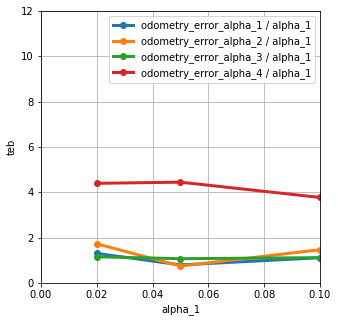

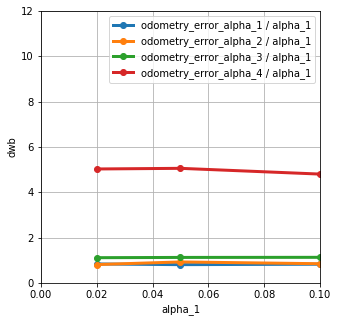

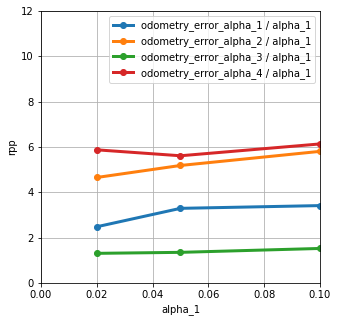

In [10]:
for local_planner_node in df.local_planner_node.unique():
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_1_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_1_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_1 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_2_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_2_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_2 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_3_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_3_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_3 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_4_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_4_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_4 / alpha_1')
    plt.legend()
    plt.ylabel(local_planner_node)
    plt.xlim([0, 0.1])
    plt.ylim([0, 12])
    plt.show()

In [11]:
df.groupby(['robot_model', 'global_planner_node', 'local_planner_node'])[localization_update_translation_mean_metrics].mean().sort_values('localization_update_absolute_translation_error_mean')

localization_update_absolute_translation_error_mean  localization_update_relative_translation_error_mean  localization_update_normalized_relative_translation_error_mean
robot_model                             global_planner_node local_planner_node                                                                                                                                                                          
hunter2                                 smac                teb                                                             0.090                                                0.012                                                0.041             
turtlebot3_waffle_performance_modelling smac                teb                                                             0.094                                                0.011                                                0.066             
                                        navfn               dwb                                                             0.098                                                0.010                                                0.049             
hunter2                                 navfn               teb                                                             0.102                                                0.013                                                0.040             
turtlebot3_waffle_performance_modelling navfn               teb                                                             0.110                                                0.011                                                0.066             
                                                            rpp                                                             0.123                                                0.011                                                0.128

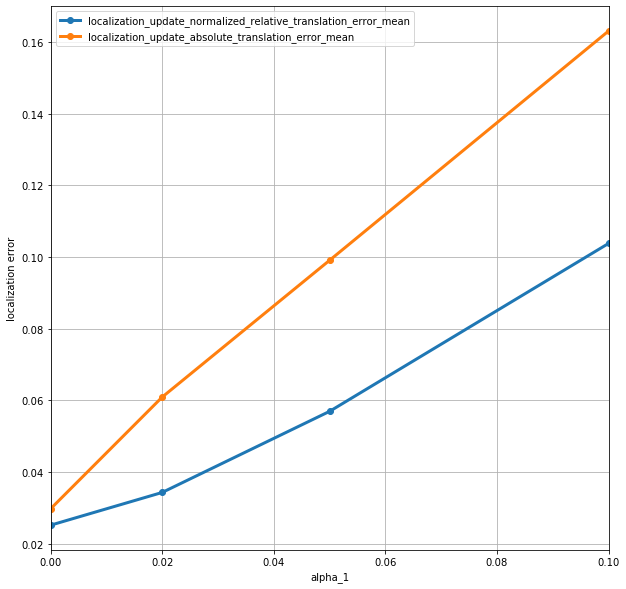

In [12]:
df.groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True)
df.groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True)
plt.legend()
plt.ylabel('localization error')
plt.show()

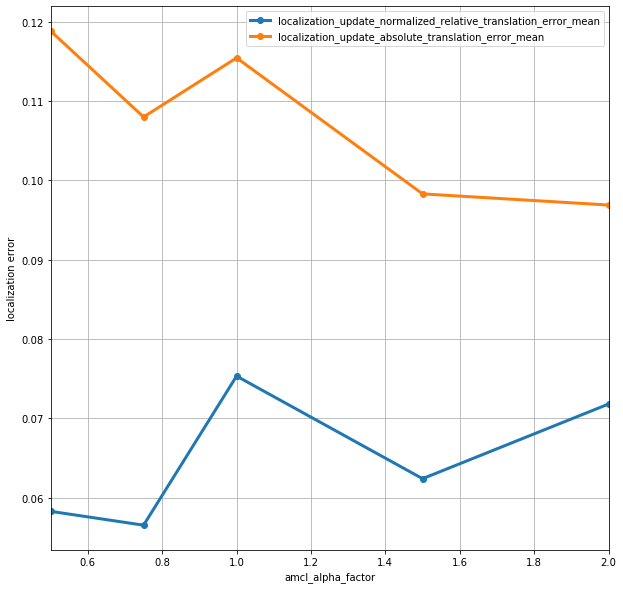

In [13]:
df[df.amcl_alpha_factor > 0].groupby(df.amcl_alpha_factor).localization_update_normalized_relative_translation_error_mean.mean().plot(x='amcl_alpha_factor', grid=True)
df[df.amcl_alpha_factor > 0].groupby(df.amcl_alpha_factor).localization_update_absolute_translation_error_mean.mean().plot(x='amcl_alpha_factor', grid=True)
plt.legend()
plt.ylabel('localization error')
plt.show()

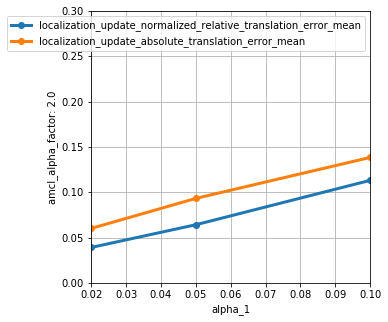

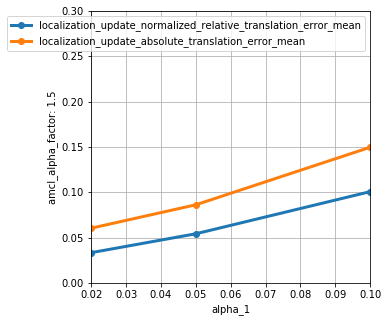

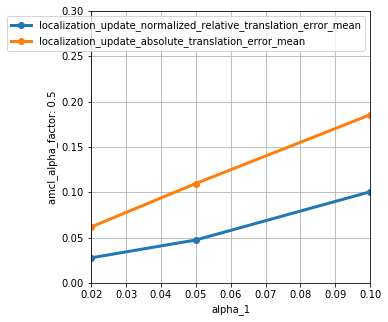

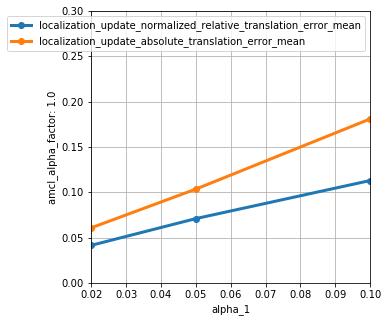

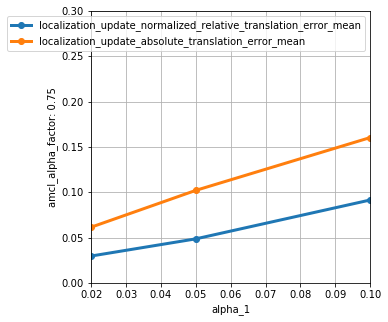

In [14]:
for amcl_alpha_factor in df[df.amcl_alpha_factor > 0].amcl_alpha_factor.unique():
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    plt.legend()
    plt.ylabel(f"amcl_alpha_factor: {amcl_alpha_factor}")
    plt.ylim([0, 0.3])
    plt.show()

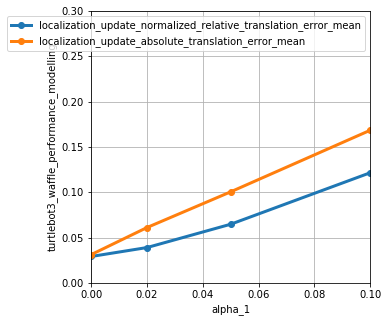

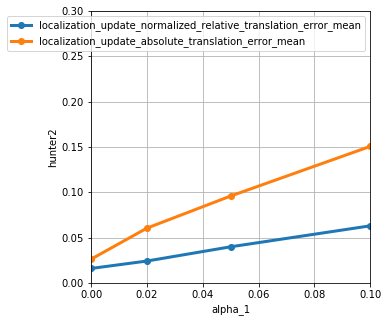

In [15]:
for robot_model in df.robot_model.unique():
    df[df.robot_model == robot_model].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    df[df.robot_model == robot_model].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    plt.legend()
    plt.ylabel(robot_model)
    plt.ylim([0, 0.3])
    plt.show()

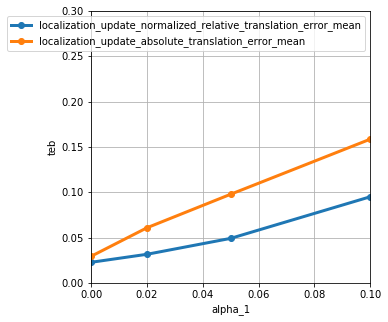

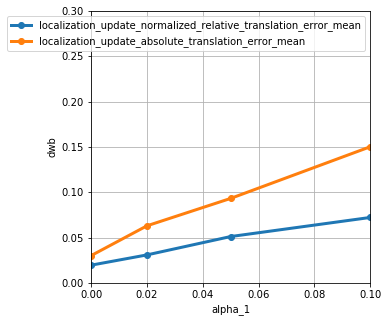

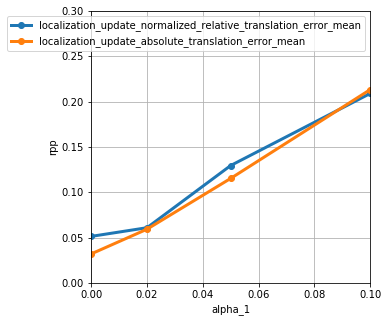

In [16]:
for local_planner_node in df.local_planner_node.unique():
    df[df.local_planner_node == local_planner_node].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    df[df.local_planner_node == local_planner_node].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
    plt.legend()
    plt.ylabel(local_planner_node)
    plt.ylim([0, 0.3])
    plt.show()

controller_cpu_time       planner_cpu_time       system_cpu_time      
                                                                                              mean count             mean count            mean count
robot_model                             local_planner_node global_planner_node                                                                       
turtlebot3_waffle_performance_modelling rpp                navfn                            31.149    96           30.035    96          76.585    96
                                        dwb                navfn                            47.407    96           32.917    96          93.741    96
hunter2                                 teb                smac                             88.014   190           29.224   190         126.501   190
turtlebot3_waffle_performance_modelling teb                smac                            107.185   288           28.216   288         145.071   288
hunter2                                 teb                navfn                           148.986   192           28.349   192         192.102   192
turtlebot3_waffle_performance_modelling teb                navfn                           156.400   283           38.038   283         210.870   283

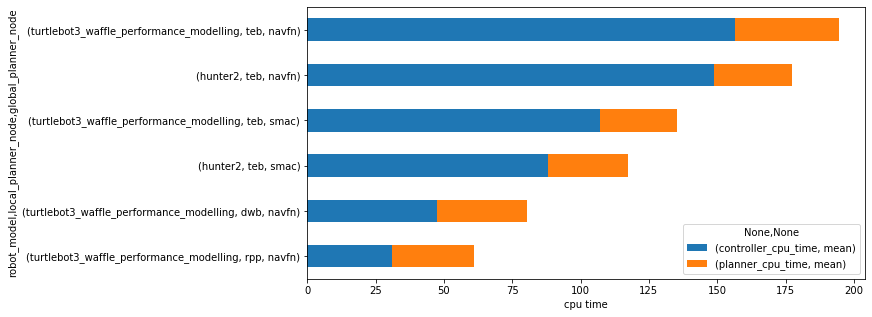

In [17]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[cpu_time_metrics].agg(['mean', 'count']).sort_values(by=('system_cpu_time', 'mean'))
ax = cpu_time_metrics_df.plot.barh(y=[('controller_cpu_time', 'mean'), ('planner_cpu_time', 'mean')], stacked=True, figsize=[10, 5],)
ax.set_xlabel("cpu time")
cpu_time_metrics_df

controller_max_memory       planner_max_memory       system_max_memory      
                                                                                                                       mean count               mean count              mean count
robot_model                             local_planner_node global_planner_node max_steering_angle_deg                                                                             
turtlebot3_waffle_performance_modelling rpp                navfn               90.000                                26.021    96             58.089    96           208.455    96
                                        dwb                navfn               90.000                                32.600    96             58.139    96           215.205    96
                                        teb                smac                90.000                                67.024    96             44.497    96           234.748    96
                                                           navfn               20.000                                68.687    96             58.374    96           251.446    96
                                                                               40.000                                68.659    95             58.647    95           252.022    95
hunter2                                 teb                navfn               20.000                                68.933    96             59.218    96           253.406    96
                                                                               40.000                                69.131    96             59.379    96           253.817    96
turtlebot3_waffle_performance_modelling teb                navfn               90.000                                68.982    92             59.555    92           254.251    92
hunter2                                 teb                smac                40.000                                67.715    95            945.393    95         1,136.564    95
turtlebot3_waffle_performance_modelling teb                smac                40.000                                68.051    96          2,279.514    96         2,471.200    96
hunter2                                 teb                smac                20.000                                68.077    95          2,882.372    95         3,075.226    95
turtlebot3_waffle_performance_modelling teb                smac                20.000                                67.486    96          6,552.701    96         6,743.703    96

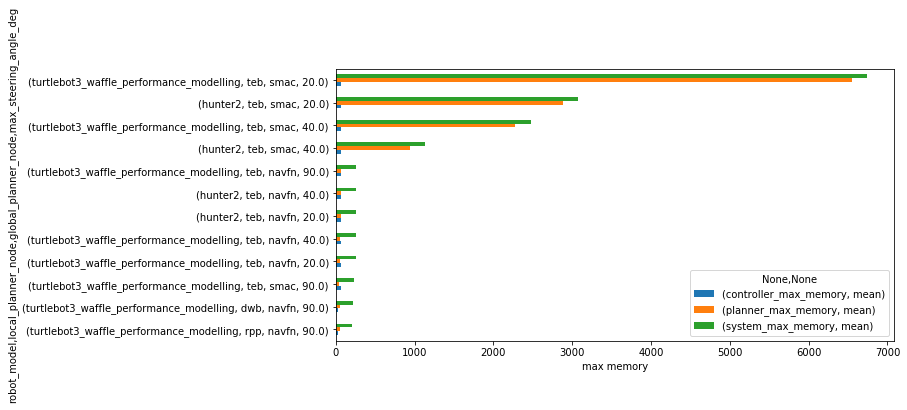

In [18]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node, df.max_steering_angle_deg])[max_memory_metrics].agg(['mean', 'count']).sort_values(by=('system_max_memory', 'mean'))
ax = cpu_time_metrics_df.plot.barh(y=[('controller_max_memory', 'mean'), ('planner_max_memory', 'mean'), ('system_max_memory', 'mean')], figsize=[10, 5], legend=True)
ax.set_xlabel("max memory")
cpu_time_metrics_df